In [ ]:
!pip install transformers
!pip install gensim

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 32.2 MB/s 
     |████████████████████████████████| 596 kB 23.0 MB/s 
     |████████████████████████████████| 895 kB 35.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=942140a5fa85a45d380043e712229eee7bacadfd40c3202e2a7c80f3adbf865a
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.8 GB  |     Proc size: 120.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [ ]:
import argparse
from datetime import datetime
import os
import time
import pandas as pd
import numpy as np
import shutil
import pickle
from google.colab import  drive
import os
import random

import matplotlib.pyplot as plt
import time

from transformers import GPT2Tokenizer,GPT2LMHeadModel,AdamW,get_linear_schedule_with_warmup
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,Dataset
from torch.cuda.amp import GradScaler,autocast

from tqdm import tqdm
from tqdm.notebook import  trange,tnrange

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
drive.mount('/content/gdrive', force_remount=True)
DATA_PATH = 'gdrive/Shared drives/Text_Summarization_Project/'
pickles_folder = os.listdir(DATA_PATH)

Mounted at /content/gdrive


In [ ]:
# Create a Pickle file dump
def pickle_dump(use_file_name,data_obj):
  local_path = os.path.join(DATA_PATH,use_file_name)
  filedump = open(local_path,'wb')
  pickle.dump(data_obj,filedump)
  filedump.close()
  print('Dump object created with filename : ',DATA_PATH+use_file_name)

# Create a Pickle file Load
def pickle_load(use_file_name):
  local_path = os.path.join(DATA_PATH,use_file_name)
  fileload = open(local_path,'rb')
  data2 = pickle.load(fileload)
  fileload.close()
  return data2

#calculates no of words in newsroom articles
def calc_article_sizes(file_name, name):
  max_len = 0
  article_sizes = {}
  print("Calculating",name, "Article Sizes......")
  data = pickle_load(file_name)
  data['text_len'] = data['text'].apply(lambda x: len(x.split()))
  max_len = data['text_len'].max()
  max_len_indx = data['text_len'].idxmax()
  article_sizes = data['text_len'].to_dict()
  return max_len, max_len_indx, article_sizes


Calculating Newsroom Article Sizes......
saving_article_files_sizes_info...
Dump object created with filename :  gdrive/Shared drives/Text_Summarization_Project/newsroom_article_file_sizes.pickle


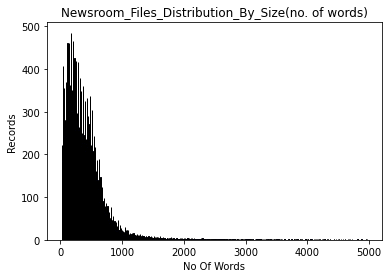

max_length_of_article_in_article:  4960  and file_index is  73242
total_time_taken 14.915528059005737  seconds
mean_length_of_article_articles:  395.0455076408039
max_10_lengths_of_article_articles: [4717 4812 4820 4823 4866 4870 4876 4945 4955 4960]
number_of_articles_greater_than_1000_words:  3217
number_of_articles_greater_than_1500_words:  1173
number_of_articles_greater_than_2000_words:  606


In [ ]:
start = time.time()
# max_len, max_len_filename, article_sizes = calc_article_sizes('processed_data_gpt2.dat', 'newsroom')
max_len, max_len_filename, article_sizes = calc_article_sizes('data_processed_for_gpt2.pickle', 'Newsroom')
sorted_article_values = np.array(sorted(article_sizes.values()))
print("saving_article_files_sizes_info...")

pickle_dump('newsroom_article_file_sizes.pickle',article_sizes)
# print(len(pd.Series(sorted_article_values).value_counts()))
# new_frame = pd.Series(sorted_article_values)
# remove_max_vals = 
#plot the distribution of articles sizes
plt.hist(sorted_article_values.tolist(),color='blue',bins=2377, edgecolor = 'black')
plt.title("Newsroom_Files_Distribution_By_Size(no. of words)")
plt.xlabel('No Of Words')
plt.ylabel('Records')
plt.show()

print('max_length_of_article_in_article: ',max_len, " and file_index is ", max_len_filename)
print("total_time_taken",(time.time()-start), " seconds")
print("mean_length_of_article_articles: ", sum(article_sizes.values())/len(article_sizes))
print("max_10_lengths_of_article_articles:", sorted_article_values[-10:])
print("number_of_articles_greater_than_1000_words: ", sum(sorted_article_values>1000))
print("number_of_articles_greater_than_1500_words: ", sum(sorted_article_values>1500))
print("number_of_articles_greater_than_2000_words: ", sum(sorted_article_values>2000))

In [ ]:
special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>'}
# data_file = pickle_load('processed_data_gpt2.dat')
data_file = pickle_load('data_processed_for_gpt2.pickle')
del sorted_article_values

data_file = data_file.reset_index(drop=True)
# data_file['text_total_len'] = data_file['text'].apply(lambda x: len(x.split()))
# data_file = data_file[data_file['text_total_len'] <= 5000]
# pickle_dump('data_processed_for_gpt2.pickle',data_file)
data_file['cummulative_length'] = data_file['text_word_count'] + data_file['sum_word_count'] 
data_file = data_file[data_file['cummulative_length'] <= 1023]


In [ ]:
data_file.head()

,title,text,summary,compression_bin,coverage_bin,density_bin,text_sent_count,sum_sent_count,text_word_count,text_char_count,text_word_density,text_sent_density,sum_word_count,sum_char_count,sum_word_density,sum_sent_density,sent_word_count,sum_sent_word_count,text_total_len,cummulative_length
0,Watch Closing Arguments : People.com,edt aaron hernandez coming close attorney form...,former new england patriot star face murder ch...,medium,medium,mixed,1,1,206,1313,0.156773,0.004831,11,59,0.183333,0.083333,206.0,11.0,206,217
1,REGIONS EUROPE - THE GERMAN LOCOMOTIVE LOSES S...,bonn economic summit meeting western leader we...,bonn economic summit meeting western leader we...,low,high,extractive,1,1,473,3030,0.156054,0.002110,73,468,0.155650,0.013514,473.0,73.0,473,546
2,Activate London 2011: David Edelstein,david director grameen foundation technology c...,david director grameen foundation technology c...,low,high,extractive,1,1,71,499,0.142000,0.013889,53,378,0.139842,0.018519,71.0,53.0,71,124
3,India Becoming a Crucial Cog in the Machine at...,bangalore india june  world biggest computer ...,india provides ibm fastestgrowing market cruci...,high,high,extractive,1,1,595,3858,0.154185,0.001678,11,73,0.148649,0.083333,595.0,11.0,595,606
4,Books Of The Times,christopher lehmannhaupt life imitates world s...,christopher lehmannhaupt life imitates world s...,low,high,extractive,1,1,504,2915,0.172840,0.001980,63,348,0.180516,0.015625,504.0,63.0,504,567


In [ ]:
data_file['text'][0]

'edt aaron hernandez coming close attorney former new england patriot star rested case monday calling three witness closing argument scheduled begin tuesday morning despite short defense presentation trial marathon prosecution called witness stand since trial began jan semiprofessional football player dating sister hernandez fiance shayanna jenkins time murder prosecutor hernandez two men picked lloyd home early morning hour june according testimony drove lloyd secluded industrial park north attleborough massachusetts shot six time prosecutor alleged hernandez orchestrated killing case hernandez without problem prosecutor never presented possible motive killing witness murder weapon never found still prosecution key circumstantial evidence prof hernandez killed lloyd among evidence home surveillance video taken minute shooting show hernandez gripping black item look like gun well joint found near lloyd body dna men it last week prosecution called shayanna jenkins stand testified hernan

In [ ]:
train_type = 'extractive'
if train_type=='extractive':
  pre_train_dataset = data_file[(data_file['density_bin'] == 'extractive') | (data_file['density_bin'] == 'Mixed') ].copy().reset_index(drop=True)
elif train_type == 'abstractive':
  pre_train_dataset = data_file[(data_file['density_bin'] == 'abstractive') | (data_file['density_bin'] == 'Mixed') ].copy().reset_index(drop=True)
else:
  pre_train_dataset = data_file[data_file['density_bin']=='Mixed'].copy().reset_index(drop=True)

pre_train_dataset = pre_train_dataset[['text','summary']].copy()
del data_file
# train_text,train_summary = pre_train_dataset['text'],pre_train_dataset['summary']

In [ ]:
pickle_dump('updated_pre_train_dt.pickle',pre_train_dataset)

Dump object created with filename :  gdrive/Shared drives/Text_Summarization_Project/updated_pre_train_dt.pickle


In [ ]:
def add_special_tokens():

	""" Returns GPT2 tokenizer after adding separator and padding tokens """
	tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
	special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>'}
	num_add_toks = tokenizer.add_special_tokens(special_tokens)
	return tokenizer

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # if args.n_gpu > 0:
    torch.cuda.manual_seed_all(seed)
 
def word_tokenization_remove_stopwords(x):
	
	corps = nltk.word_tokenize(x)
	results = [word.replace('“','').replace('”','').replace(' ’ ','').replace('‘','').replace('—','').replace('…','').replace('•','').replace('¦','').replace('\x80','').replace('\x95','') for word in corps if word not in stopwords]
	final_txt = " ".join(results)
	return final_txt

tokenizer = add_special_tokens()
# pre_train_dataset['text'] = pre_train_dataset['text'].apply(lambda x: word_tokenization_remove_stopwords(x))
# pre_train_dataset['summary'] = pre_train_dataset['summary'].apply(lambda x: word_tokenization_remove_stopwords(x))

In [ ]:
class SummaryDataset(Dataset):

  def __init__(self,X,y,index,length=None,mode='train'):
    self.tokenizer = add_special_tokens()
    self.len = length
    self.input = X
    self.target = y
    self.mode = mode
    self.idxs = index 

  def __len__(self):
    return self.len

  def __getitem__(self,idx):

    if self.mode=='valid':
      idx = self.idxs[-idx]
    elif self.mode=='test':
      idx = self.idxs[-idx-self.len]   # assuming valid and test set of same sizes
    else:
      idx = self.idxs[idx]
    
    text = self.tokenizer.encode(self.tokenizer.pad_token)*1024
    content = self.input[idx] + self.tokenizer.sep_token + self.target[idx]

    token_vecs = self.tokenizer.encode(content)
    
    if len(token_vecs) > 1024:
      token_vecs = token_vecs[:1024]
    
    text[:len(token_vecs)] = token_vecs
    final_val = torch.tensor(np.array(text))
    # print('Tensor shape: ',final_val.shape,' length of token vecs : ',len(self.input[idx].split()))
    # print('Final tensor : ',final_val)
    sample = {'article': final_val, 'sum_idx': len(self.input[idx].split())}
    return sample

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            top_p > 0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """

    # print('Logits dimension : ',logits.dim())
    # assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    print('Logits size : ',logits.size(-1),end='\n\n')
    # print('Top-K : ',top_k,end='\n\n')
    if top_k > 0:
      print('In the TOP-K Loop with top_k value : ',top_k )
      print('Logits values : ',logits)
      print('Top K for cont',torch.topk(logits, top_k))
      
      # Remove all tokens with a probability less than the last token of the top-k
      indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
      print('Size of Indices to remove : ',(indices_to_remove.shape))
      print('Indices to be removed from top_k filtering: ',indices_to_remove)
      logits[indices_to_remove] = filter_value

    if top_p > 0.0:
      # print('In the Top P loop with top_p value :', top_p)
      sorted_logits, sorted_indices = torch.sort(logits, descending=True)
      # sorted_logits = logits
      # print('Sorted Logits are: ',sorted_logits)
      # print('softmax result = ',F.softmax(sorted_logits))
      cumulative_probs = torch.cumsum(F.softmax(sorted_logits,dim=-1),dim=-1)
      # print('Cummulative Probability : ',cumulative_probs)
      # Remove tokens with cumulative probability above the threshold
      sorted_indices_to_remove = cumulative_probs > top_p
      # Shift the indices to the right to keep also the first token above the threshold
      sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
      sorted_indices_to_remove[..., 0] = 0

      indices_to_remove = sorted_indices[sorted_indices_to_remove]
      # print('Indices to remove from top_p filtering: ',indices_to_remove)
      logits[indices_to_remove] = filter_value
    # print('Logits type : ',type(logits))
    # print('Logits shape : ',logits.shape)
    # print('Logits indices :',logits)
    return logits

def sample_seq(model, context, length, device, temperature=1, top_k=0, top_p=0.0):

  context = torch.tensor(context, dtype=torch.long, device=device)
  context = context.unsqueeze(0)
  generated = context
  # generated = torch.nan_to_num(context,nan=2.0,posinf=1.0)
  
  # print('Generated Context: ',generated)
  print('Length of Sequence: ',length)
  set_seed(42)
  with torch.no_grad():
    for _ in tnrange(length):

      inputs = {'input_ids': generated}
      print(inputs['input_ids'])
      device_inps = inputs['input_ids'].to(device)
      outputs = model(inputs)
      # print('Outputs generated: ',outputs)
      # outputs = model.generate(device_inps,max_length=1,top_k=0) #,top_p=0.5,temperature=0.8       
      next_token = torch.multinomial(F.softmax(outputs, dim=-1,dtype=torch.float), num_samples=1)
      print('Generated Next Token : ',next_token)
      generated = torch.cat((generated, next_token), dim=1) #.unsqueeze(0)
      
  return generated

 
def generate_sample(data, tokenizer, model, num=1, eval_step=False, length=100, temperature=0.7, top_k=100, top_p=0.5, device=torch.device('cuda')):
  """ Generate summaries for "num" number of articles.
        Args:
            data = GPT21024Dataset object
            tokenizer = gpt/gpt2 tokenizer
            model = gpt/gpt2 model
            num = number of articles for which summaries has to be generated
            eval_step = can be True/False, checks generating during evaluation or not
    """     
  # print('Value of Num: ', num)
  for i in range(num):
    sample = data[i]
    idx = sample['sum_idx']
    context = sample['article'][:idx].tolist()
    # print('Validation Context : ',context)
    summary = sample['article'][idx+1:][:100].tolist()
    # print('Validation Summary : ',summary)
    generated_text = sample_seq(model, context, length, device, temperature, top_k, top_p)

    generated_text = generated_text[0, len(context):].tolist()
    print('Generated Summary text : ',generated_text)
    text = tokenizer.convert_ids_to_tokens(generated_text,skip_special_tokens=True)
    text = tokenizer.convert_tokens_to_string(text)
    if eval_step==False:
        print('new_article', end='\n\n')
        print(tokenizer.decode(context), end='\n\n')
        print("generated_summary", end='\n\n')
        print(text, end='\n\n')
        print('actual_summary', end='\n\n')
        print(tokenizer.decode(summary), end='\n\n')
    else:
        print(tokenizer.decode(context), end='\n\n')
        print("generated_summary", end='\n\n')




In [ ]:
num_train_epochs =  5
batch_size=1
gradient_accumulation_steps= 32
learning_rate = 5e-5
maximum_gradient_normalization = 1
scaler = GradScaler()

def train(model,tokenizer,train_dataset,valid_dataset,indexes):
  
  training_sample = RandomSampler(train_dataset)
  train_dl = DataLoader(train_dataset,sampler=training_sample,batch_size=batch_size)
  loss_function = CrossEntropyLoss(ignore_index=indexes)
  optimizer = AdamW(model.parameters(),lr=learning_rate)
  # scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,warmup_steps=200,t_total= 80000,last_epoch=-1)
  scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=200,num_training_steps= 80000)
  
  global_step,tr_loss,log_loss = 0,0.0,0.0
  model.zero_grad()
  train_iterator = trange(int(num_train_epochs),desc='Epoch')
  set_seed(42)
  
  for _ in train_iterator:
    epoch_iterator = tqdm(train_dl, desc="Training")
    for step, batch in enumerate(epoch_iterator):
      X_train,y_train = batch['article'].clone().detach(),batch['article'].clone().detach()
      
      X_train = X_train.to(device=device)
      y_train = y_train.to(device=device)
      model.train()
      with autocast():
        y_train_predicted = model(X_train)[0]
        # print('Predicted Train:',y_train_predicted)
        idx = batch['sum_idx'].item()
        shift_logits = y_train_predicted[..., batch['sum_idx']:-1, :].contiguous()
        shift_labels = y_train[..., batch['sum_idx']+1:].contiguous()
        train_losses = loss_function(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

      train_losses = train_losses/gradient_accumulation_steps
      scaler.scale(train_losses).backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), maximum_gradient_normalization)
      tr_loss += train_losses.item()

      print('Training Loss : ',train_losses)
      if (step + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        model.zero_grad()
        global_step += 1
        logging_loss = tr_loss
        print("loss:", train_losses.item(), end='\n\n')
        if (step + 1)/gradient_accumulation_steps == 1.0:
          print('After 1st update: ', end='\n\n')
          generate_sample(valid_dataset, tokenizer,model, num=2, eval_step=False,device=device) #,temperature=0.7,top_k=200,top_p=0.5
                
                
      if (step + 1) % (10*gradient_accumulation_steps) == 0:
        results = evaluate(model, valid_dataset, indexes, global_step)
        print('After', global_step+1,'updates: ', end='\n\n')
        generate_sample(valid_dataset, tokenizer,model, num=2, eval_step=True,device=device)
 

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('Device Used: ',device)
printm()
pre_train_dataset = pickle_load('updated_pre_train_dt.pickle')
training_set = int(pre_train_dataset.shape[0]*0.7)
validation_set = int(pre_train_dataset.shape[0]*0.3)
index = pre_train_dataset.index 
train_dataset = SummaryDataset(pre_train_dataset['text'],pre_train_dataset['summary'],index,training_set,'train')
valid_dataset = SummaryDataset(pre_train_dataset['text'],pre_train_dataset['summary'],index,validation_set,'valid')
# print('Validation dataset size : ',valid_dataset)
ignore_idx = tokenizer.pad_token_id
#  read batches of RAM and not on Disk space.
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to(device)
print('After Model loading')
printm()
# del pre_train_dataset
torch.cuda.empty_cache()

Device Used:  cuda:0
Gen RAM Free: 24.3 GB  |     Proc size: 6.1 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB
After Model loading
Gen RAM Free: 24.3 GB  |     Proc size: 6.4 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


In [ ]:
train(model,tokenizer,train_dataset,valid_dataset,ignore_idx)

In [ ]:
text = pre_train_dataset['text'][0]
inp_ids = tokenizer.encode(text)

'bonn economic summit meeting western leader west germany staunchly resisted call use head economic steam like locomotive tug europe lagging economy recession oil crisis induced end however germany politician industrialist flattered anyone asked play locomotive cost oil still climbing europe economy locked another downturn west germany run steam leader becoming increasingly pessimistic people remain convinced germany still one line heavier piece rolling stock also came realize immune economic difficulty plague industrialized nation sure began well west germany fear spiraling oil price led factory owner stockpile industry booked heavy order assembly line hummed growth first quarter acceptable percent second quarter however pace slackened consumer spending eased energy cost rose order overseas dried developing country spent money oil rather turnkey plant west germany production slowed ripple united state recession begun earlier year interest rate screwed ever higher fight inflation sprea

In [ ]:
def evaluate(args, model, eval_dataset, ignore_index, global_step=None):
    """ Returns perplexity score on validation dataset.
        Args:
            args: dict that contains all the necessary information passed by user while training
            model: finetuned gpt/gpt2 model
            eval_dataset: GPT21024Dataset object for validation data
            global_step: no. of times gradients have backpropagated
            ignore_index: token not considered in loss calculation
    """
    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=batch_size)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_idx) #ignores padding token for loss calculation

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['article'].to(device), batch['article'].to(device)
        
        with torch.no_grad():
            logits = model(inputs)[0]
            idx = batch['sum_idx'].item() # index of separator token
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            lm_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {
        "perplexity": perplexity
    }
    print("perplexity:", perplexity.item())

    if global_step:
        output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
        with open(output_eval_file, "a") as f:
            for key in sorted(result.keys()):
                f.write('\n\n')
                f.write("time = %s, %s = %s, step = %s\n" % (datetime.now().strftime("%d/%m/%Y %H:%M:%S"), key, str(result[key]), str(global_step)))
    return result

In [ ]:
tokenizer.decode(187)

'�'

In [ ]:
logits_val = torch.tensor([[ 4189,    77,  3034, 14237,  3249,  8830,  3554,  7421,   308,  2224,
            88, 34700,   306, 26643,   869,   779,  1182,  3034, 13324,   588,
         33334, 19138, 27762, 11063,   431,   300, 16406,  3773, 16457,  3056,
          4902, 18268,   886,  2158,   308,  2224,    88, 14971,  7593,   396,
          6228,  4400,  2687,  1965,   711, 33334, 19138,  1575,  3056,   991,
         14281, 11063,   431,  3773,  8970,  1194, 34540,  7421,   308,  2224,
            88,  1057, 13324,  3554,  5033,  6481, 46392,   661,  3520,  9431,
           308,  2224,    88,   991,   530,  1627, 20140,  3704, 10708,  4283,
           635,  1625,  6537, 10900,  3034,  8722, 23684, 47670,  3277,  1654,
          2540,   880,  7421,   308,  2224,    88,  3252,  9158,  4272,  3056,
          2756,  2957,  8860,  4870, 45360,  2831, 21765,  4334,  1502, 10474,
          1627,  1311,  1150,  3349,   717,  3860, 10909,  1411,  1218,  3860,
          2158,  8761, 30740,  2945,  7172,  4581, 44828,  2568,  1575,  8278,
          1502, 11292, 16577,  5922,  1499,  3377,  1637,  3056,  2138,  1210,
          2539,  4618,  7421,   308,  2224,    88,  3227, 20955, 42462, 16503,
          1181, 16457,  9258,  2961,   614,  1393,  2494, 27527,  1683,  2440,
          1907, 10610,  4104,  1973,   379,    75,  5109,  2063,  4286, 16083,
           308,  2224,    88, 24873,  1754,  1459,  1848,  1262,  1913, 10784,
         12042, 11677,  3139,   308,  2224,  1664,  1325, 10522,  1637,   308,
          2224, 18473,  4341, 11292, 11091,  2160,  3215,  8383,  3758,   736,
          1641,  1295,   588, 26876,   331,  1018, 26388,   544,  6087, 30740,
          2945, 10784, 18939,  3220,  6074,  1330,  1871,  1517, 16378,  3056,
          9812,   503, 10724,   308,  2224, 18473, 10522,  3236, 11292,  7593,
          4896,  1509, 11978, 11807,  2997,  2997, 11807,  5322,  1459,  1848,
         23565,   903,  1459,  1848,  3751, 18201,  3016,  2997,  2938,  2997,
         11807,   614,   308,  2224,    88,  3034, 11949,  4318,  3331, 12207,
           274, 17796,  1266,  4729,  3139,   736,   308,  2224,    88,  8620,
          1994, 20983,  2494,  1700,  6001,   938,  6076,  1230,  1816, 23669,
           473, 47928,   610,   397,   544,  1969,  7625,  3953, 13027,  1943,
          1854,  3181, 19125,  1735,  1245,  1029,  1393,  2494,  2626,   881,
         17416,  1625,   640, 16503,  1181,  1907, 15229,   328,   270, 10610,
           635, 13663,  1393,  2494,   477,  2435,  1029,  3090,   925,  1637,
          5789, 21151,  3101,  3773,   640,   867,  7026,  1637,  2622,   336,
          2088,  2046,  1029, 16503,  1181,  1393,  2494, 12725, 15811,   308,
          2224,  1317,  8872,  4073,  1317,  4268,  1988,  1411,  3688,  8872,
           938,   614,   614,   886,  1317,  5365,  1877,  1988,  1642,  1330,
         16378, 16842, 10610,   560, 23642,   308,  2224,    88,  1310, 10717,
          7794, 10784,  4073,  8688, 16457,   614,  4444, 19360,  4438,  1310,
         45194, 19318,  2023,  5351,    77,  5342, 12446,   267, 33955, 30592,
          1443, 40180,   487, 11001,  3034,  3349,  6632,  1411,  8972, 19547,
         46400,  6466,   989,   308,  2224,    88,  1936,  2957,   278,  3034,
         24224,  2938,  1499,  1103, 10319,  2260,  1720,  1302,   991,  1411,
          3349,  3726,   649,   614,   772,  3870,   527, 17724,  3177, 16915,
          2209,  3277, 30006, 18030,   315,  5513, 21184,  7728,  1327,  3704,
          2975,  9105,  4058,   334,  6919,  1884, 12053, 17724, 17646,  2282,
          3034,  3842, 22085,   881,  1411,   614,  5526, 17646,  4412, 14969,
           962,  1499,  2368, 28209,  5068,  3331,  7172,  7067,  1884,     0]])

In [ ]:
logits_val[0, 349:].tolist()

In [ ]:
txt = pre_train_dataset['text'][0]
print(txt,end='\n\n')
input_ids = tokenizer.encode(txt,return_tensors='pt')
model.to('cpu')
outputs = model.generate(input_ids=input_ids,max_length=50)
prediction = []
for element in outputs:
  prediction.append(tokenizer.decode(element,skip_special_tokens=True))
' '.join(prediction)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 564, but ``max_length`` is set to 50. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


bonn economic summit meeting western leader west germany staunchly resisted call use head economic steam like locomotive tug europe lagging economy recession oil crisis induced end however germany politician industrialist flattered anyone asked play locomotive cost oil still climbing europe economy locked another downturn west germany run steam leader becoming increasingly pessimistic people remain convinced germany still one line heavier piece rolling stock also came realize immune economic difficulty plague industrialized nation sure began well west germany fear spiraling oil price led factory owner stockpile industry booked heavy order assembly line hummed growth first quarter acceptable percent second quarter however pace slackened consumer spending eased energy cost rose order overseas dried developing country spent money oil rather turnkey plant west germany production slowed ripple united state recession begun earlier year interest rate screwed ever higher fight inflation spread

'bonn economic summit meeting western leader west germany staunchly resisted call use head economic steam like locomotive tug europe lagging economy recession oil crisis induced end however germany politician industrialist flattered anyone asked play locomotive cost oil still climbing europe economy locked another downturn west germany run steam leader becoming increasingly pessimistic people remain convinced germany still one line heavier piece rolling stock also came realize immune economic difficulty plague industrialized nation sure began well west germany fear spiraling oil price led factory owner stockpile industry booked heavy order assembly line hummed growth first quarter acceptable percent second quarter however pace slackened consumer spending eased energy cost rose order overseas dried developing country spent money oil rather turnkey plant west germany production slowed ripple united state recession begun earlier year interest rate screwed ever higher fight inflation sprea

In [ ]:
# torch.multinomial(F.softmax(logits_val, dim=-1,dtype=torch.float), num_samples=1)
logits_val = logits_val.t()
next_token = torch.multinomial(F.softmax(logits_val, dim=-1,dtype=torch.float),num_samples=1)
# generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
next_token

In [ ]:
next_token.t().unsqueeze(0)

In [ ]:
F.softmax(logits_val,dtype=torch.float,dim=0)

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)


num_train_epochs =  3
batch_size=1
gradient_accumulation_steps= 64
learning_rate = 5e-3
maximum_gradient_normalization = 1
scaler = GradScaler()
sample_every = 100

def train(model,tokenizer,train_dataset,valid_dataset,indexes):
  
  training_sample = RandomSampler(train_dataset)
  train_dl = DataLoader(train_dataset,sampler=training_sample,batch_size=batch_size)
  valid_dl = DataLoader(valid_dataset)
  loss_function = CrossEntropyLoss(ignore_index=indexes)
  optimizer = AdamW(model.parameters(),lr=learning_rate)
  # scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,warmup_steps=200,t_total= 80000,last_epoch=-1)
  scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=200,num_training_steps= 80000,last_epoch=-1)
  

  for epoch_i in range(0, num_train_epochs):

      # ========================================
      #               Training
      # ========================================

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      t0 = time.time()

      total_train_loss = 0

      model.train()

      for step, batch in enumerate(train_dl):

          X_train,y_train = batch['article'].clone().detach(),batch['article'].clone().detach()
      
          X_train = X_train.to(dtype=torch.long, device=device)
          y_train = y_train.to(dtype=torch.long, device=device)
          
          model.zero_grad()        

          outputs = model(  X_train,
                            labels=y_train, 
                            # attention_mask = b_masks,
                            token_type_ids=None
                          )

          loss = outputs[0]  

          batch_loss = loss.item()
          total_train_loss += batch_loss

          # Get sample every x batches.
          if step % sample_every == 0 and not step == 0:

              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

              model.eval()

              sample_outputs = model.generate(
                                      bos_token_id=random.randint(1,30000),
                                      do_sample=True,   
                                      top_k=50, 
                                      max_length = 200,
                                      top_p=0.95, 
                                      num_return_sequences=1
                                  )
              for i, sample_output in enumerate(sample_outputs):
                    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
              
              model.train()

          loss.backward()

          optimizer.step()

          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)       
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================

      print("")
      print("Running Validation...")

      t0 = time.time()

      model.eval()

      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          b_input_ids = batch[0].to(device)
          b_labels = batch[0].to(device)
          b_masks = batch[1].to(device)
          
          with torch.no_grad():        

              outputs  = model(b_input_ids, 
  #                            token_type_ids=None, 
                              attention_mask = b_masks,
                              labels=b_labels)
            
              loss = outputs[0]  
              
          batch_loss = loss.item()
          total_eval_loss += batch_loss        

      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      validation_time = format_time(time.time() - t0)    

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
tokenizer.decode(281)

' an'